CLOUD ANALYSIS
--------------

In this notebook, we will go over the analysis which is helpful for imagery enhancement under cloud probability.

**Change directory**

We are working in notebook folder, we want to fake as if this notebook is in the main dir.

In [284]:
#Do this to work on main dir
import os
os.chdir("/home/bill/GitHub/wps-research/data/bill")

**Load libraries**

Reload

In [285]:
import importlib

In [286]:
import SAFE
import raster
import plot_tools

importlib.reload(SAFE)
importlib.reload(raster)
importlib.reload(plot_tools)

<module 'plot_tools' from '/home/bill/GitHub/wps-research/data/bill/plot_tools.py'>

In [287]:
#Main libs
from raster import Raster
from misc.general import htrim_3d

In [288]:
#Visual libs
from plot_tools import plot, plot_multiple
import matplotlib.pyplot as plt

In [289]:
#Built-in libs
import numpy as np


**Load Data**

File names

In [290]:
file1 = 'C11659/L2A/extracted/S2C_MSIL2A_20251014T192401_N0511_R099_T09UYU_20251014T222816.bin'
file2 = 'C11659/L2A/extracted/S2A_MSIL2A_20251016T192831_N0511_R099_T09UYU_20251016T220315.bin'

cloudf_1 = 'C11659/L2A/cloud_60m/S2C_MSIL2A_20251014T192401_N0511_R099_T09UYU_20251014T222816_CLDPRB_60m.bin'
cloudf_2 = 'C11659/L2A/cloud_60m/S2A_MSIL2A_20251016T192831_N0511_R099_T09UYU_20251016T220315_CLDPRB_60m.bin'


Load objects

In [291]:
obj1 = Raster(file1)
dat1 = obj1.read_bands()

obj2 = Raster(file2)
dat2 = obj2.read_bands()

cloud1 = Raster(cloudf_1)
cloud_dat_1 = cloud1.read_bands().squeeze()

cloud2 = Raster(cloudf_2)
cloud_dat_2 = cloud2.read_bands().squeeze()

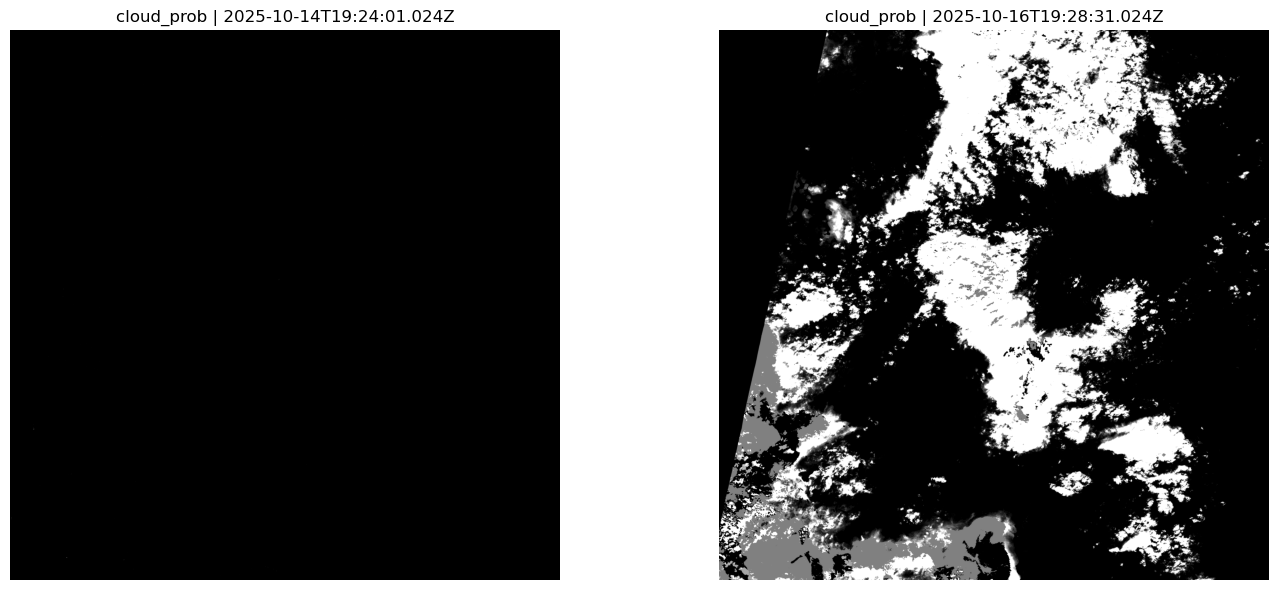

In [292]:
plot_multiple(X_list=[cloud_dat_1, cloud_dat_2], 
              title_list=[f'cloud_prob | {cloud1.meta['acquisition_time']}',
                          f'cloud_prob | {cloud2.meta['acquisition_time']}'],
              max_per_row=2)

In [293]:
for i, b in enumerate(obj1.band_info_list) : 
    print(i, b)

0 B01
1 B02
2 B03
3 B04
4 B05
5 B06
6 B07
7 B8A
8 B09
9 B11
10 B12
11 SCL


**Planning**
------------

Upon the current belief: 
+ Thicker cloud can bend the spectral intensity in a more rigorous way. If that trend is learnable, we can contruct what is underneath the cloud (at least to a lower probability cloud).

Challenges
+ We basically depend on cloud prob provided by Corpenicus, which is not perfect.

+ Cloud probability doesn't mean a certain thickness of cloud, it can be predicted based on various factors, spectral combination and cloud, only swir and cloud, ... We basically do not know (if we did, we would have a perfect classifier.)

Questions

+ Using the 2 rasters. With the cloud mask of the later date, can I reconstruct partially cloud/smoke/... covered area? 

Process

+ 

+ Build a function which let us choose a cloud probability interval, with a band, so that it will give us 2 colours of scatter. 

    -> Red which are cloud covered of the chosen probability, Blue are not cloud covered (All areas with another probability of cloud will be exclusive).

Will we see anything? Will it be learnable? Try construct!

**All the parts with no cloud in both days, will the signal stay the same?**

In [294]:
from cuml.ensemble import RandomForestRegressor
import cupy as cp

In [295]:
cloud_mask = np.logical_or(cloud_dat_1.astype(np.bool_), cloud_dat_2.astype(np.bool_))

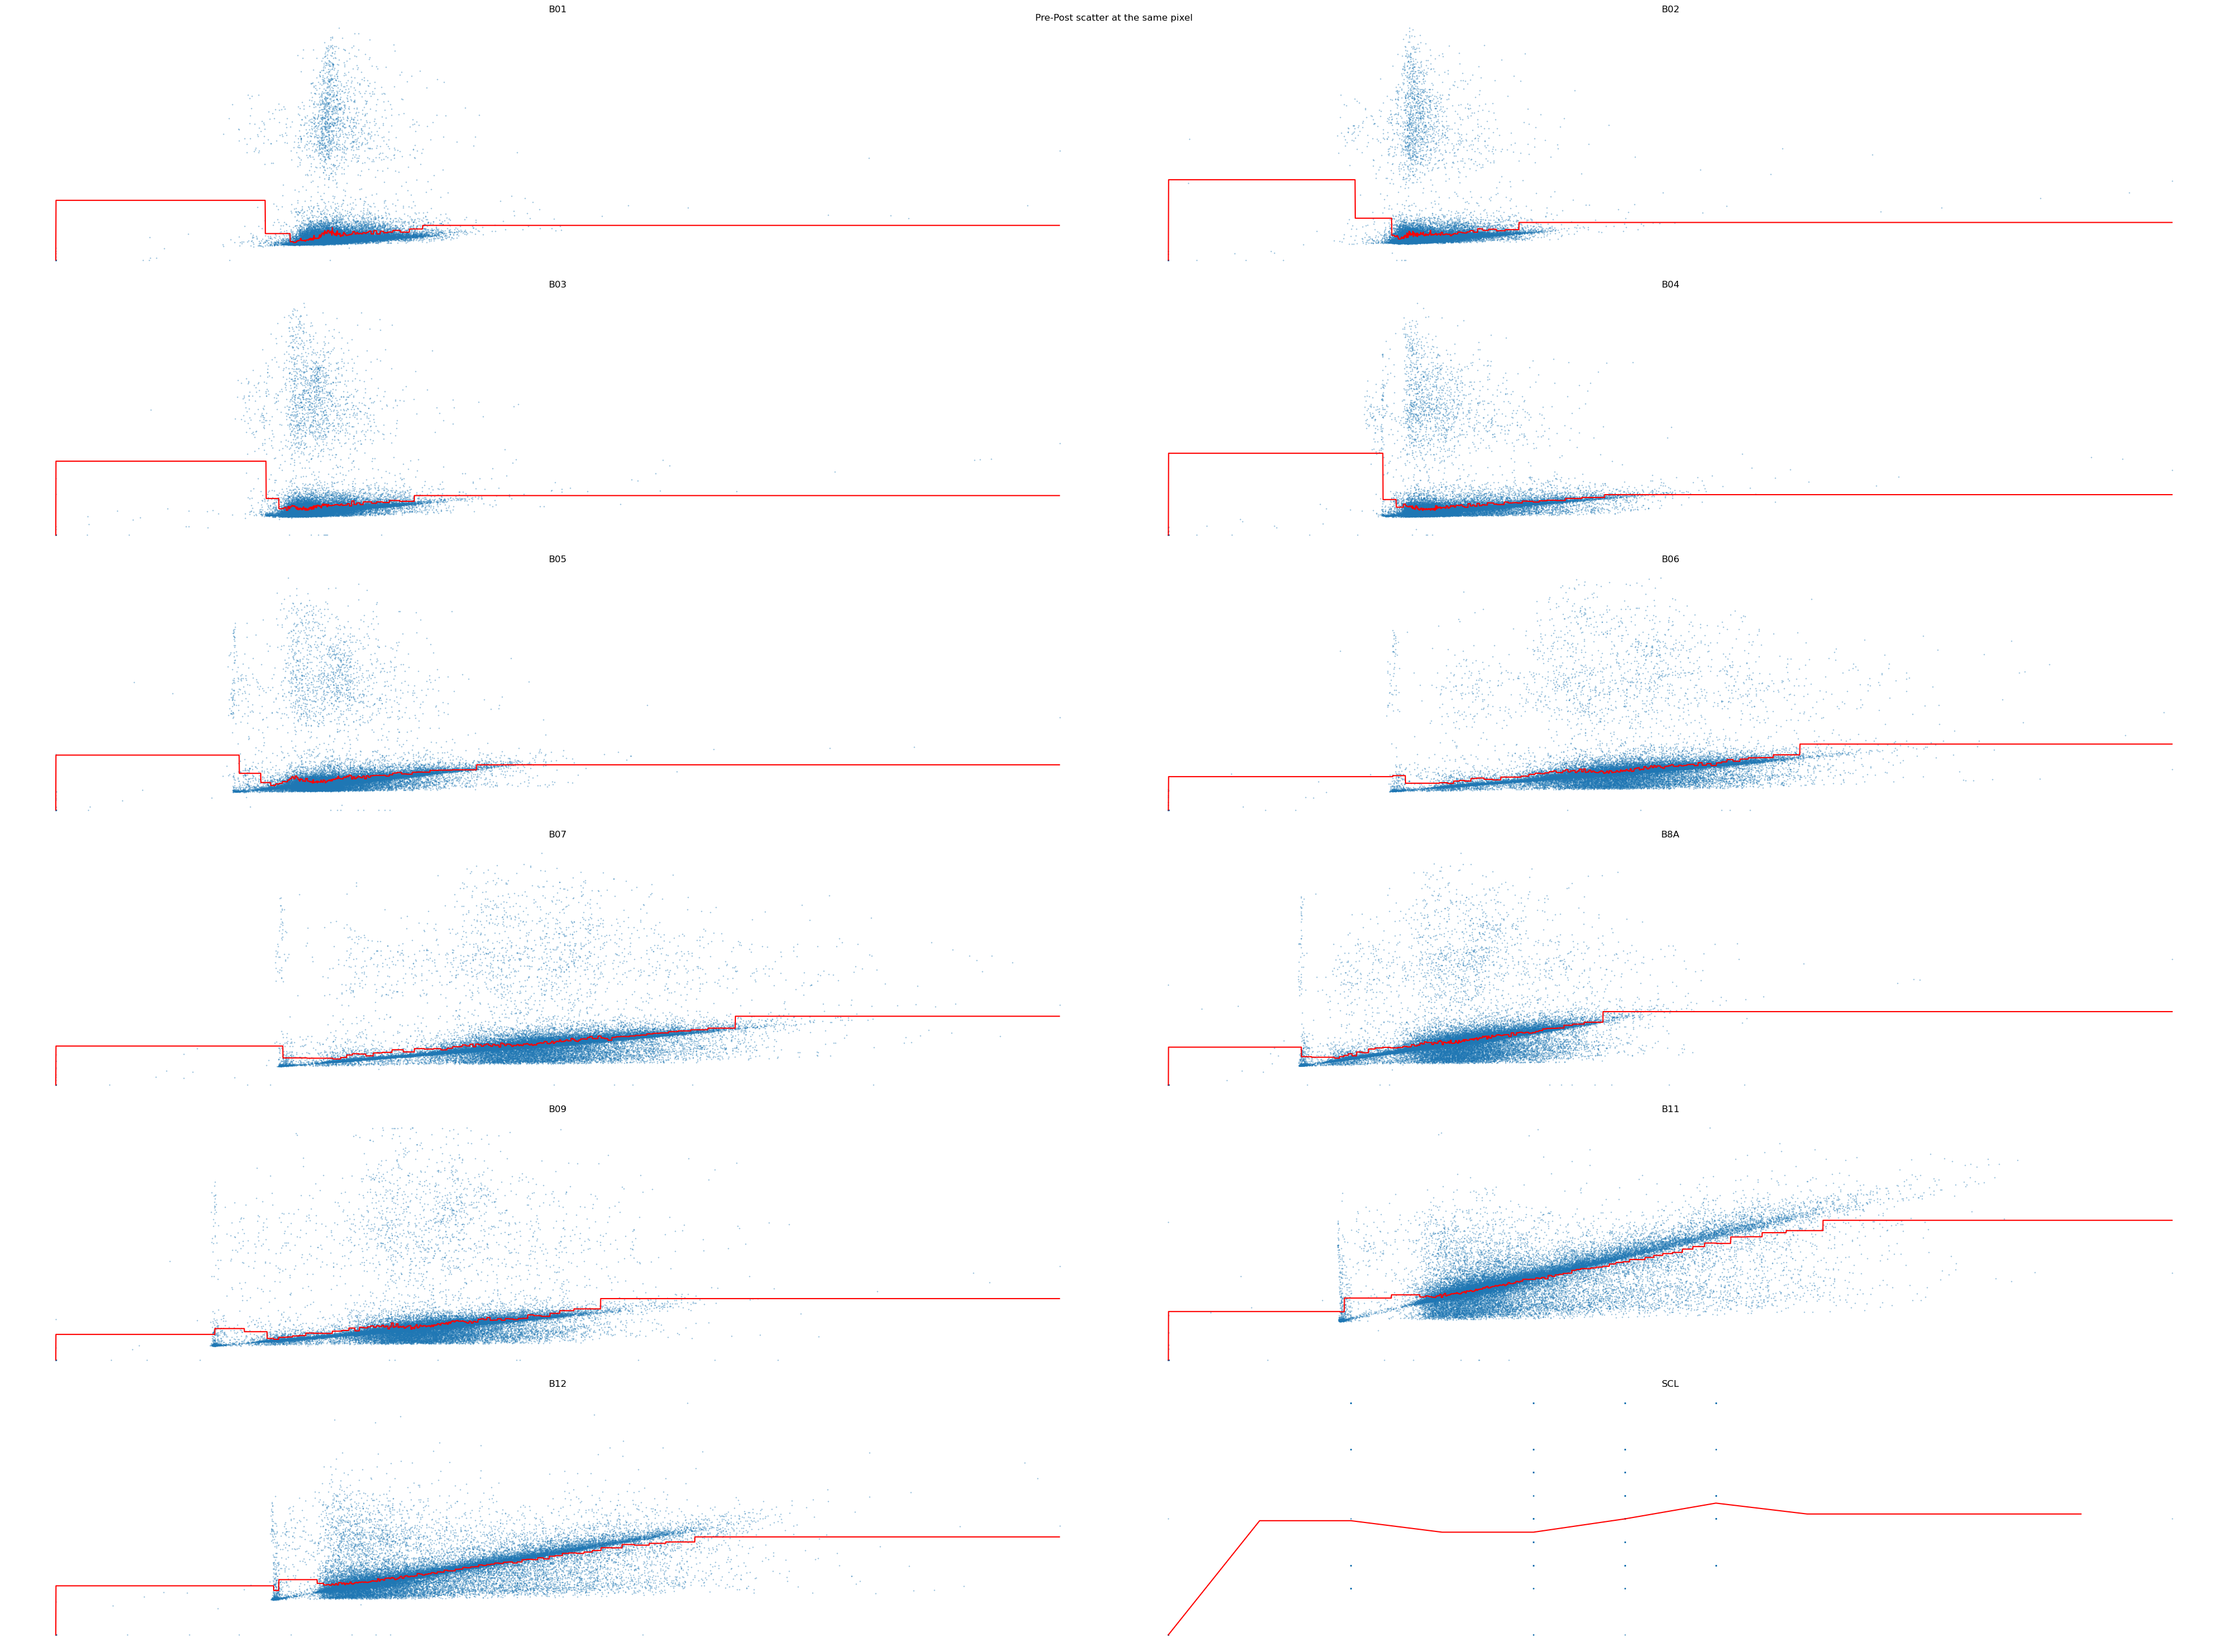

In [296]:
n_bands = 12
n_cols = 2
n_rows = int(np.ceil(n_bands / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(20 * n_cols, 5 * n_rows),
    squeeze=False
)

for id in range(n_bands):
    row = id // n_cols
    col = id % n_cols
    ax = axes[row, col]

    dat1_nc = dat1[..., id][~cloud_mask].ravel()
    dat2_nc = dat2[..., id][~cloud_mask].ravel()

    n = min(50_000, len(dat1_nc))
    idx = np.random.choice(len(dat1_nc), size=n, replace=False)
    
    x = dat1_nc[idx]
    y = dat2_nc[idx]
    
    #Bonus, prediction
    params = {
        'n_estimators': 100,    
        'max_depth': 15,
        'max_features': "sqrt",
        'random_state': 42
    }

    lr = RandomForestRegressor(
        **params
    )
    lr.fit(x.reshape(-1, 1), y)
    
    x_pred = np.arange(x.min(), x.max()).reshape(-1, 1)
    y_pred = lr.predict(x_pred)

    # ----------------------------------
    # Percentile-based limits (per band)
    # ----------------------------------

    ax.scatter(x, y, s=0.1)
    ax.plot(x_pred, y_pred, c = 'red')

    ax.set_title(f"{obj1.band_info_list[id]}")
    ax.axis("off")

# Turn off unused subplots (if any)
for k in range(n_bands, n_rows * n_cols):
    axes[k // n_cols, k % n_cols].axis("off")

plt.suptitle('Pre-Post scatter at the same pixel')
plt.tight_layout()
plt.show()

**Observation of spectral shift**

For these specific 2 dates, there seems to be a separate trend in the first band (band 1) and starts to disappear as band goes up, likely be effected by wave length:

i.e: The higher band, the longer wavelength it is. Probably it affects the way the trend shows up. Generally, for later bands (which we will use more often), we can see a linear trend, suggest a shift in band data can be inferred.

**Try to fake what is under the cloud**

We will try to first, predict what should be under that cloud. 

Only infer the data at cloud mask. Dont touch real data.

CAUTION: it would make no practical sense to predict something under that cloud if we cant actually use the information, those part should be marked as NO DATA.

In [297]:
from cuml.linear_model import LinearRegression
import cupy as cp

In [ ]:
dat = dat2.copy()

for i in range(8, 11):

    dat1_nc = dat1[..., i][~cloud_mask].reshape(-1, 1)
    dat2_nc = dat2[..., i][~cloud_mask].ravel()
    
    X = cp.asarray( dat1_nc )
    y = cp.asarray( dat2_nc )

    # lr = LinearRegression(fit_intercept=True)
    params = {
        'n_estimators': 100,    
        'max_depth': 20,
        'max_features': "sqrt",
        'random_state': 42
    }

    lr = RandomForestRegressor(
        **params
    )
    
    lr.fit(X, y)

    under_cloud_pred = lr.predict(dat1[..., i][cloud_mask].reshape(-1, 1))

    dat[..., i][cloud_mask] = under_cloud_pred

In [315]:
#Compare the plots
X = dat1[..., [10, 9, 8]]
X1 = dat2[..., [10, 9, 8]]
X2 = dat [..., [10, 9, 8]]

p = 1

lo, hi = np.nanpercentile(X1, p, axis=(0, 1)), np.nanpercentile(X1, 100 - p, axis=(0, 1))

In [316]:
main = (X - lo) / (hi - lo)

show_1 = (X1 - lo) / (hi - lo)

show2 =  (X2 - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


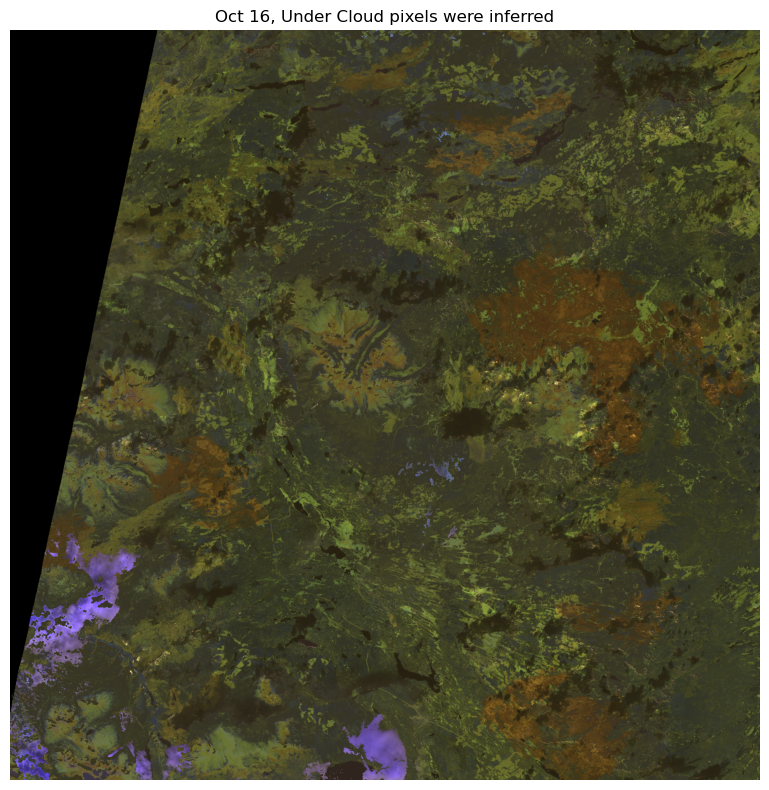

In [317]:
plot(show2, title='Oct 16, Under Cloud pixels were inferred')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


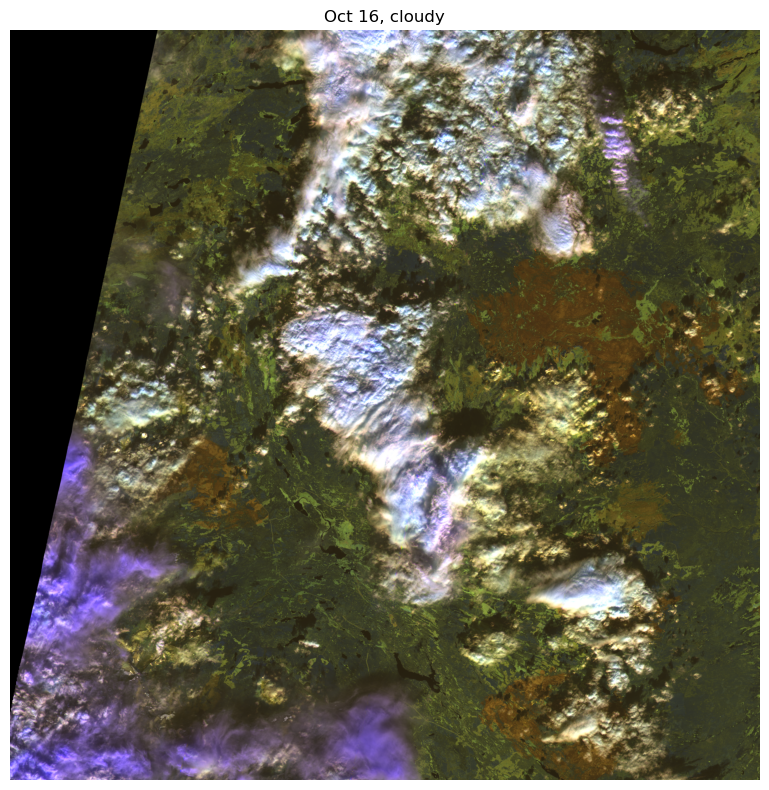

In [308]:
plot(show_1, title='Oct 16, cloudy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


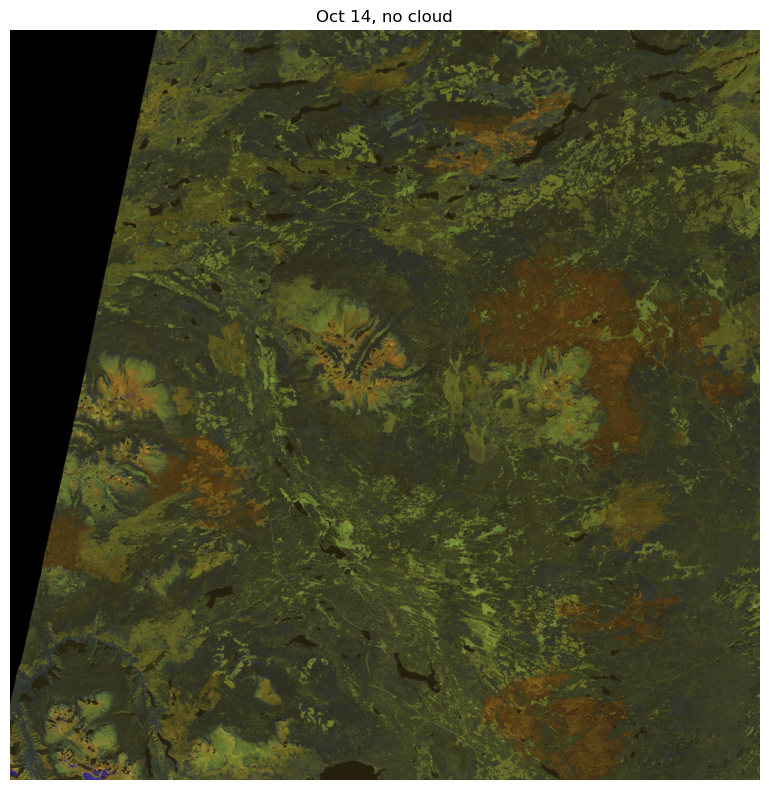

In [309]:
plot(main, title='Oct 14, no cloud')

In [ ]:
asddas #for error

NameError: name 'asddas' is not defined

**The Masks**
-------------

Next step, we need to study how the mask (cloud, snow, ...) affects the band intensity. We will need to separate into bins of cloud probability,

Cloud distribution in this specific plot.

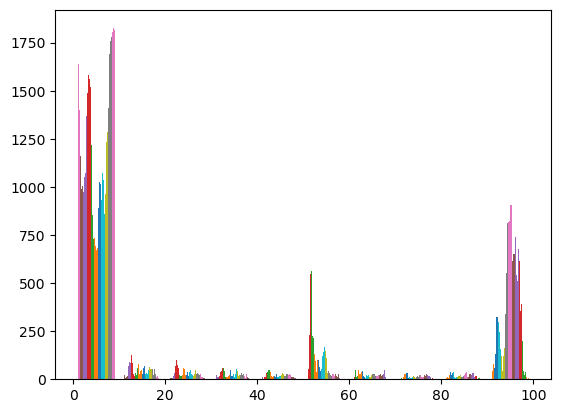

In [ ]:
# plt.hist(
#     cloud_dat_2
# )

# plt.show()

In [ ]:
def plot_cloud_by_bin(
        a, b
):
    #Prepare masks

    mask = np.logical_and(( (cloud_dat_2 > a) & (cloud_dat_2 < b) ), 
                                 ~cloud_dat_1.astype(np.bool_))

    n_bands = 12
    n_cols = 2
    n_rows = int(np.ceil(n_bands / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(20 * n_cols, 10 * n_rows),
        squeeze=False
    )

    for id in range(n_bands):
        row = id // n_cols
        col = id % n_cols
        ax = axes[row, col]

        dat1_c = dat1[mask].ravel()
        dat2_c = dat2[mask].ravel()

        # ----------------------------------
        # Percentile-based limits (per band)
        # ----------------------------------

        ax.scatter(dat1_c, dat2_c, s=0.1, c = 'green')

        ax.set_title(f"Band {obj1.band_info_list[id]} | Pixel count {mask.sum()}")
        ax.axis("off")

    # Turn off unused subplots (if any)
    for k in range(n_bands, n_rows * n_cols):
        axes[k // n_cols, k % n_cols].axis("off")
        
    plt.tight_layout()
    plt.show()

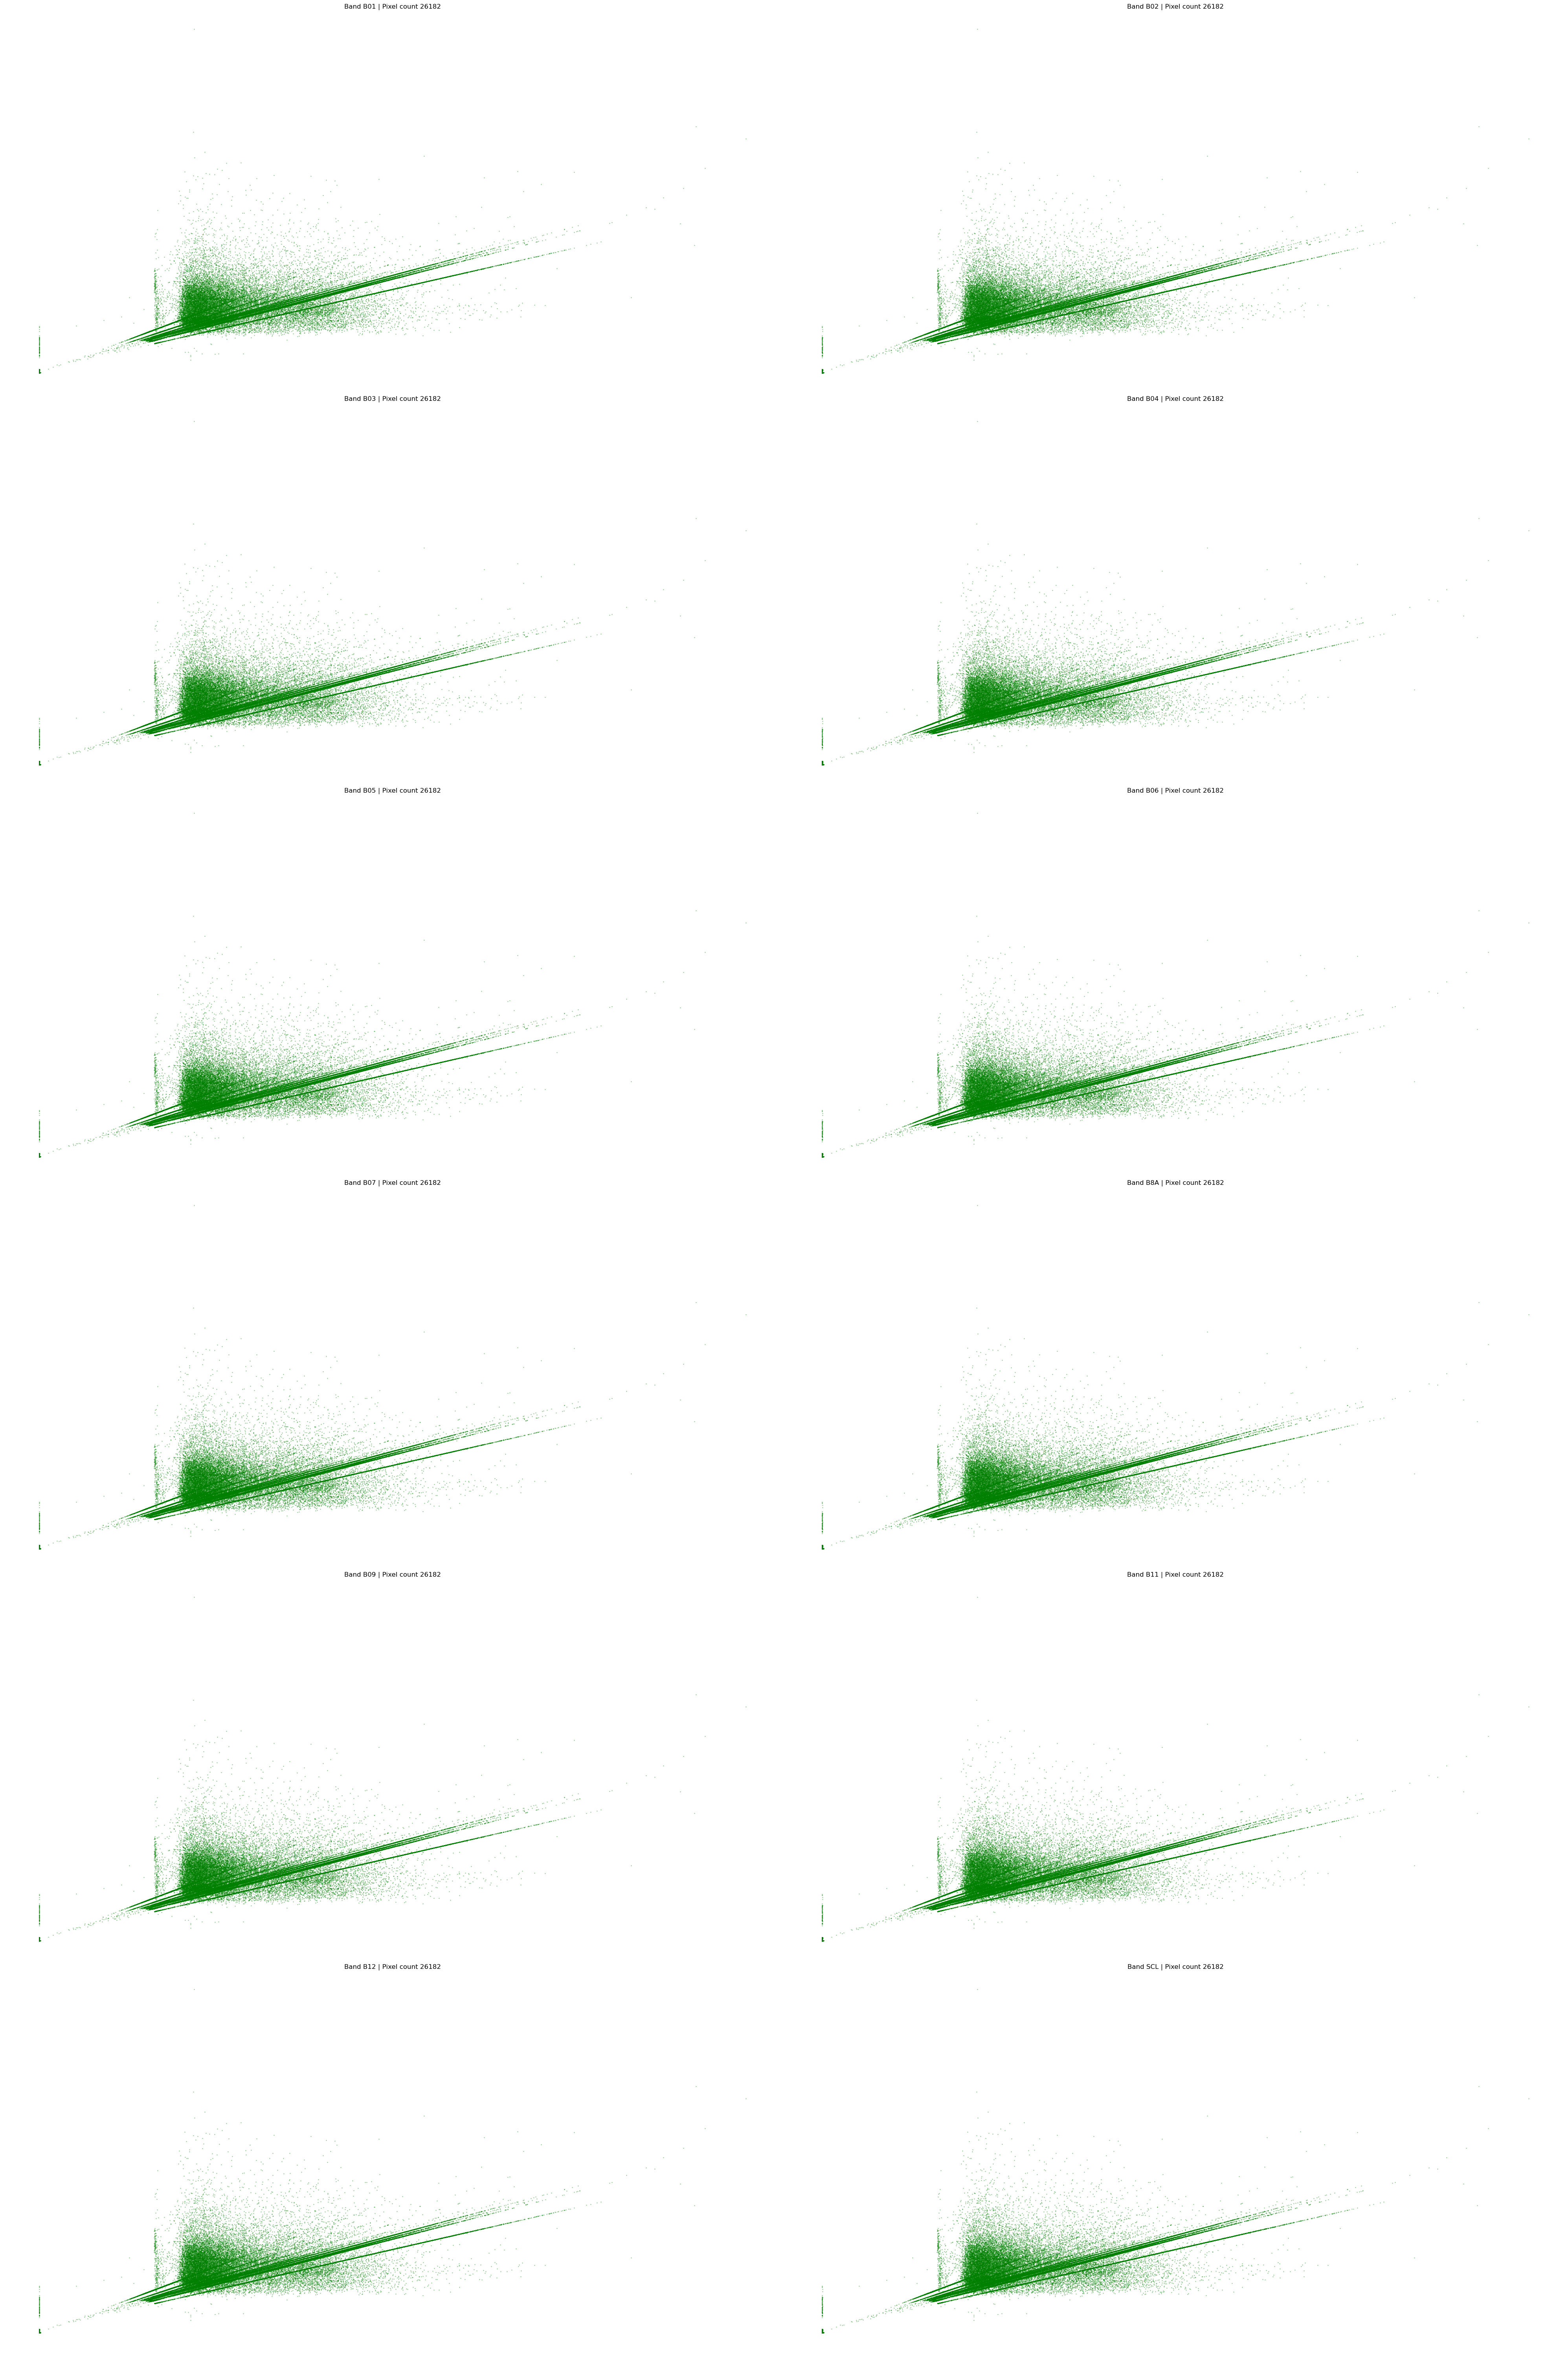

In [ ]:
plot_cloud_by_bin(15, 20)